In [1]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [14]:
print( cartopy.__version__ )
print( np.__version__ )
print( matplotlib.__version__ )

0.21.1
1.23.5
3.7.0


In [16]:
gfe_lon = np.fromfile('ref/gfe0p01d_lon.bin', 'f4').reshape(525, 575)
gfe_lat = np.fromfile('ref/gfe0p01d_lat.bin', 'f4').reshape(525, 575)
print(gfe_lon)
print(gfe_lat)

[[117.78 117.79 117.8  ... 123.5  123.51 123.52]
 [117.78 117.79 117.8  ... 123.5  123.51 123.52]
 [117.78 117.79 117.8  ... 123.5  123.51 123.52]
 ...
 [117.78 117.79 117.8  ... 123.5  123.51 123.52]
 [117.78 117.79 117.8  ... 123.5  123.51 123.52]
 [117.78 117.79 117.8  ... 123.5  123.51 123.52]]
[[21.48 21.48 21.48 ... 21.48 21.48 21.48]
 [21.49 21.49 21.49 ... 21.49 21.49 21.49]
 [21.5  21.5  21.5  ... 21.5  21.5  21.5 ]
 ...
 [26.7  26.7  26.7  ... 26.7  26.7  26.7 ]
 [26.71 26.71 26.71 ... 26.71 26.71 26.71]
 [26.72 26.72 26.72 ... 26.72 26.72 26.72]]


In [3]:
sea_mask = np.zeros(301875, '?')
with open('gfe0p01d_land_sea.txt') as fid:
    fid.readline()
    for iline, line in enumerate(fid):
        if int(line.split()[4]) == 0:
            sea_mask[iline] = True

In [4]:
wd = np.fromfile('FST_202310050000TAU0024_301875_wd.bin', 'f4').reshape(525, 575)
ws = np.fromfile('FST_202310050000TAU0024_301875_ws.bin', 'f4').reshape(525, 575)
theta_d = (450 - wd) % 360
theta_d = (theta_d + 180)%360
theta = theta_d * np.pi / 180
u10 = ws * np.cos(theta)
v10 = ws * np.sin(theta)

In [5]:
qpf = np.fromfile('FST_202310050000TAU0024_301875_QPF1hr.bin', 'f4')
qpf_land = qpf.copy()
qpf_land[sea_mask] = np.nan
qpf = qpf.reshape(525, 575)

radius = 6371000
area = (0.01 * np.pi/180 * radius) * (0.01 * np.pi/180 * radius) * np.cos(gfe_lat * np.pi/180)
total_water = np.nansum(qpf_land * area.reshape(-1))*1e-3

33016731.648000002


In [6]:
tmax = np.fromfile('FST_202310050000TAU0024_301875_Tmax.bin', 'f4')
tmax[sea_mask] = np.nan
tmax = tmax.reshape(525, 575)

In [7]:
def precipitation_cmap():

    boundary = [
        0, 0.1, 1, 2, 6, 10, 15, 20, 30, 40, 
        50, 70, 90, 110, 130, 150, 200, 300, 400
    ]
    hex_list = [
        '#ffffff', '#c1c1c1', '#99ffff', '#00ccff', '#0099ff', '#0066ff', '#339900', '#33ff00', '#ffff00', '#ffcc00', '#ff9900',
        '#ff0000', '#cc0000', '#990000', '#990099', '#cc00cc', '#ff00ff', '#ffccff'
    ]
    colorlist = []
    for hex in hex_list:
        colorlist.append(matplotlib.colors.to_rgb(hex))
    n_bin = len(colorlist)
    cmap_name = 'precipitation'
    mycmap = LinearSegmentedColormap.from_list(
        cmap_name,
        colorlist,
        N=n_bin
    )
    mynorm = matplotlib.colors.BoundaryNorm(boundary, n_bin)
    return mycmap, mynorm, boundary

In [8]:
def temperature_cmap():

    boundary = [
        -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
        10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
        30, 31, 32, 33, 34, 35, 36, 37
    ]
    hex_list = [
        '#000080', '#0000cd', '#0000ff', '#0040ff', '#006aff', '#0095ff', '#00bfff', '#00eaff', '#00ffea', '#80fff4',
        '#117388', '#207e92', '#2e899c', '#3d93a6', '#4c9eb0', '#5ba9ba', '#69b4c4', '#78bfce' ,'#87cad8', '#96d4e2',
        '#a4dfec', '#b3eaf6', '#0c924b', '#1d9a51', '#2fa257', '#40a95e', '#51b164', '#62b96a', '#74c170', '#85c876',
        '#96d07c', '#a7d883', '#b9e089', '#cae78f', '#dbef95', '#f4f4c3', '#f7e78a', '#f4d576', '#f1c362', '#eeb14e',
        '#ea9e3a', '#e78c26', '#e07b03', '#ed5138', '#ed1759', '#ad053a', '#780101', '#9c68ad'
    ]
    colorlist = []
    for hex in hex_list:
        colorlist.append(matplotlib.colors.to_rgb(hex))
    n_bin = len(colorlist)
    cmap_name = 'temperature'
    mycmap = LinearSegmentedColormap.from_list(
        cmap_name,
        colorlist,
        N=n_bin
    )
    mynorm = matplotlib.colors.BoundaryNorm(boundary, n_bin)
    return mycmap, mynorm, boundary

In [9]:
def wind_speed_cmap():

    boundary = [
        0, 0.5, 1.0, 4.0, 7.0, 11.0, 17.0, 22.0, 28.0, 34.0, 
        41.0, 48.0, 56.0, 64.0, 72.0, 81.0, 90.0, 100.0, 109., 119.0,
        120.0
    ]
    hex_list = [
        '#ffffff', '#e6e6e6', '#d3d3d3', '#979797', '#646464', '#96d2fa', '#1464d5', '#34d53a', '#ffe87c', '#ffa001',
        '#ff1500', '#820000', '#663e32', '#b48c82', '#ffc8c8', '#e68282', '#d45050', '#641616' ,'#321414', '#1e0a0a'
    ]
    colorlist = []
    for hex in hex_list:
        colorlist.append(matplotlib.colors.to_rgb(hex))
    n_bin = len(colorlist)
    cmap_name = 'windspeed'
    mycmap = LinearSegmentedColormap.from_list(
        cmap_name,
        colorlist,
        N=n_bin
    )
    mynorm = matplotlib.colors.BoundaryNorm(boundary, n_bin)
    return mycmap, mynorm, boundary

In [10]:
shape_feature_tw = cfeature.ShapelyFeature(
    shpreader.Reader('gadm36_TWN_shp/gadm36_TWN_2').geometries(),
    ccrs.PlateCarree(), 
    facecolor='none',
    linewidth=0.3
)
shape_feature_ch = cfeature.ShapelyFeature(
    shpreader.Reader('CHN_adm/CHN_adm1').geometries(),
    ccrs.PlateCarree(), 
    facecolor='none',
    linewidth=0.3
)

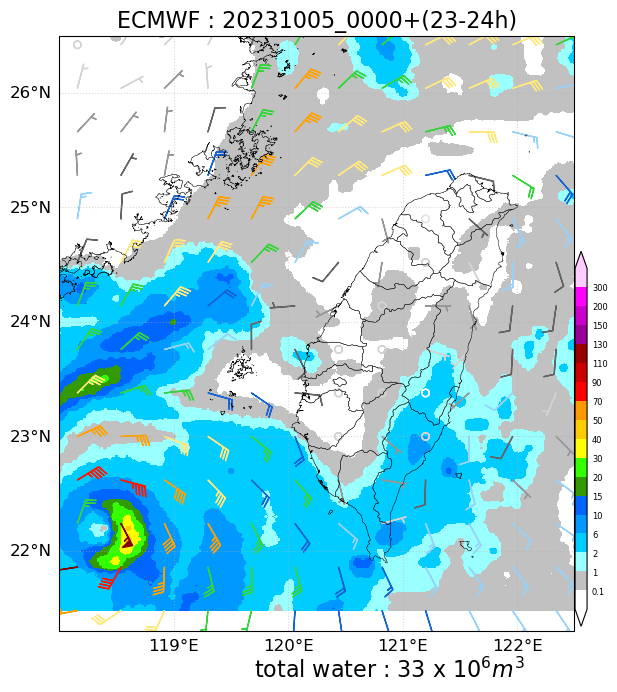

In [11]:
mycmap, mynorm, boundary = precipitation_cmap()

fig = plt.figure(figsize=(6, 7.5))
ax = fig.add_axes((0.082, 0.064, 0.859, 0.873), projection=ccrs.PlateCarree())
ax.set_extent([118, 122.5, 21.3, 26.5], ccrs.PlateCarree())

ax.add_feature(shape_feature_tw)
ax.add_feature(shape_feature_ch)

gd0 = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=':')
gd0.top_labels = False
gd0.right_labels = False
gd0.xlocator = mticker.FixedLocator([118, 119, 120, 121, 122])
gd0.ylocator = mticker.FixedLocator([22, 23, 24, 25, 26])
gd0.xformatter = LONGITUDE_FORMATTER
gd0.yformatter = LATITUDE_FORMATTER
gd0.xlabel_style = {'size': 12}
gd0.ylabel_style = {'size': 12}

ax.set_title('ECMWF : 20231005_0000+(23-24h)', fontsize=16)

pcolor = ax.pcolormesh(gfe_lon, gfe_lat, qpf, cmap=mycmap, norm=mynorm)

cbar_ax = fig.add_axes([0.942, 0.11, 0.02, 0.50])
cbar = fig.colorbar(pcolor, cax=cbar_ax, extend='both', ticks=boundary)
cbar.ax.set_yticklabels([
    '', '0.1', '1', '2', '6', '10', '15', '20', '30', '40', 
    '50', '70', '90', '110', '130', '150', '200', '300', ''
])
cbar.ax.tick_params(size=0, labelsize=6)

mycmap, mynorm, boundary = wind_speed_cmap()
step = 38
ax.barbs(
    gfe_lon[::step, ::step], gfe_lat[::step, ::step], 
    u10[::step, ::step]/0.51444, v10[::step, ::step]/0.51444, 
    ws[::step, ::step]/0.51444, cmap=mycmap, norm=mynorm,
    length=6
)

ax.text(119.7, 20.9, f'total water : {int(total_water//1e6)} x $10^6 m^3$', fontsize=16)

plt.savefig('qpf_demo.png')

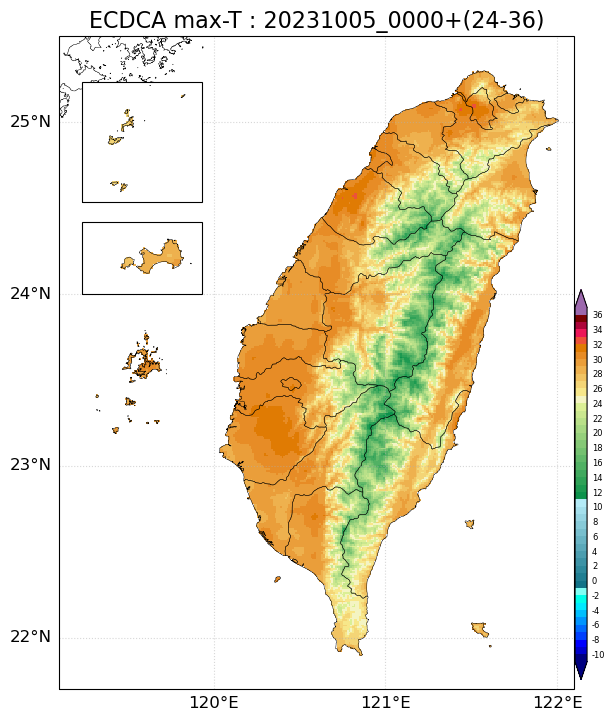

In [12]:
mycmap, mynorm, boundary = temperature_cmap()

fig = plt.figure(figsize=(6, 7.5))
ax = fig.add_axes((0.082, 0.064, 0.859, 0.873), projection=ccrs.PlateCarree())
ax.set_extent([119.1, 122.1, 21.7, 25.5], ccrs.PlateCarree())

ax.add_feature(shape_feature_tw)
ax.add_feature(shape_feature_ch)

gd0 = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=':')
gd0.top_labels = False
gd0.right_labels = False
gd0.xlocator = mticker.FixedLocator([120, 121, 122])
gd0.ylocator = mticker.FixedLocator([22, 23, 24, 25])
gd0.xformatter = LONGITUDE_FORMATTER
gd0.yformatter = LATITUDE_FORMATTER
gd0.xlabel_style = {'size': 12}
gd0.ylabel_style = {'size': 12}

ax.set_title('ECDCA max-T : 20231005_0000+(24-36)', fontsize=16)

ax_k = fig.add_axes((0.12, 0.14, 0.2, 1), projection=ccrs.PlateCarree())
ax_k.set_extent([118.05, 118.55, 24.3, 24.6])
ax_k.add_feature(shape_feature_tw)

ax_m = fig.add_axes((0.12, 0.295, 0.2, 1), projection=ccrs.PlateCarree())
ax_m.set_extent([119.8, 120.3, 25.9, 26.4])
ax_m.add_feature(shape_feature_tw)

pcolor = ax.pcolormesh(gfe_lon, gfe_lat, tmax, cmap=mycmap, norm=mynorm)
ax_k.pcolormesh(gfe_lon, gfe_lat, tmax, cmap=mycmap, norm=mynorm)
ax_m.pcolormesh(gfe_lon, gfe_lat, tmax, cmap=mycmap, norm=mynorm)

cbar_ax = fig.add_axes([0.942, 0.078, 0.02, 0.52])
cbar = fig.colorbar(pcolor, cax=cbar_ax, extend='both', ticks=boundary)
cbar.ax.set_yticklabels([
    '', -10, '', -8, '', -6, '', -4, '', -2, '', 
     0, '',  2, '',  4, '',  6, '',  8, '', 
    10, '', 12, '', 14, '', 16, '', 18, '', 
    20, '', 22, '', 24, '', 26, '', 28, '', 
    30, '', 32, '', 34, '', 36, ''
])
cbar.ax.tick_params(size=0, labelsize=6)

plt.savefig('tmax_demo.png')


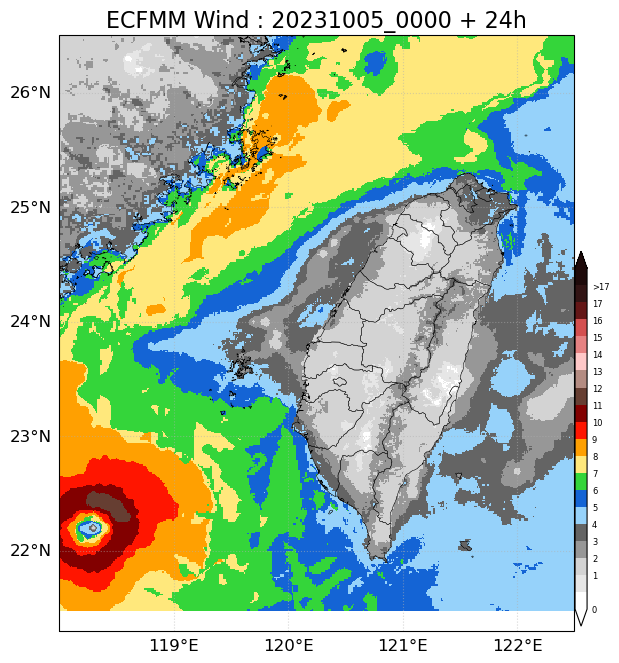

In [13]:
mycmap, mynorm, boundary = wind_speed_cmap()

fig = plt.figure(figsize=(6, 7.5))
ax = fig.add_axes((0.082, 0.064, 0.859, 0.873), projection=ccrs.PlateCarree())
ax.set_extent([118, 122.5, 21.3, 26.5], ccrs.PlateCarree())

ax.add_feature(shape_feature_tw)
ax.add_feature(shape_feature_ch)

gd0 = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=':')
gd0.top_labels = False
gd0.right_labels = False
gd0.xlocator = mticker.FixedLocator([118, 119, 120, 121, 122])
gd0.ylocator = mticker.FixedLocator([22, 23, 24, 25, 26])
gd0.xformatter = LONGITUDE_FORMATTER
gd0.yformatter = LATITUDE_FORMATTER
gd0.xlabel_style = {'size': 12}
gd0.ylabel_style = {'size': 12}

ax.set_title('ECFMM Wind : 20231005_0000 + 24h', fontsize=16)

pcolor = ax.pcolormesh(gfe_lon, gfe_lat, ws/0.5144444, cmap=mycmap, norm=mynorm)

cbar_ax = fig.add_axes([0.942, 0.11, 0.02, 0.50])
cbar = fig.colorbar(pcolor, cax=cbar_ax, extend='both', ticks=boundary)
cbar.ax.set_yticklabels([
    '0', '', '1', '2', '3', '4', '5', '6', '7', '8', 
    '9', '10', '11', '12', '13', '14', '15', '16', '17', '>17',
    ''
])
cbar.ax.tick_params(size=0, labelsize=6)

plt.savefig('wind_demo.png')